<a href="https://colab.research.google.com/github/sayu0303/Otimiza-Nao-Linear/blob/main/M%C3%89TODO_DFP(TESTE).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MINHA TENTATIVA DE FAZER O MÉTODO DE DFP (APLICANDO OS AJUSTES DO PROFESSOR)

In [121]:
'''
BLOCO PARA IMPORTAR AS BIBLIOTECAS A SEREM UTILIZADAS

'''

#Importação das bibliotecas a serem utilizadas

import numpy as np #Biblioteca para executar operações matemáticas
import pandas as pd #Leitor da minha planilha de dados
import matplotlib.pyplot as plt #Gerador de gráficos
from scipy.integrate import solve_ivp #Integração numérica para resolver a EDO


In [122]:
'''
BLOCO PARA LER MINHA PLANILHA DISPONÍVEL NO GITHUB

'''

#URL da planilha no Github

url = 'https://github.com/sayu0303/Otimiza-Nao-Linear/raw/refs/heads/main/problema6_lumped(corrigido).xlsx'

#Leitura da planilha

df_dados = pd.read_excel(url, header = 0) #Meu header é onde inicia-se a leitura da minha planilha


#Definição dos dados da planilha para utilização do código

t_exp = df_dados['t_s'].to_numpy() #Considera os valores da minha coluna t_s da planilha fornecida
tempo = t_exp.astype(float)
N = len(tempo)
T_exp = df_dados['T_C'].to_numpy() #Considera os valores da minha coluna T_C da planilha fornecida


In [123]:
'''
BLOCO PARA DEFINIR A MINHA EDO

'''

#Definição da EDO expostas no problema

def EDO (t, T, par):

  #Definição das constantes a serem utilizadas

  V = 2.5e-4 #Volume (m3)
  A = 0.045 #Área de troca térmica (m2)
  Tam = 25 #Temperatura ambiente constante (°C)
  p = 7800 #Densidade (kg/m3)
  c = 460 #Calor específico (J/kg.K)

  #Definir as variáveis propostas pelo problema

  h, qg = par #Definindo as variáveis como parametros

  #Definir a EDO

  dTdt = (qg*V/(p*c*V)) - ((h*A)*(T-Tam))/(p*c*V)

  return dTdt



In [124]:
'''
BLOCO PARA DEFINIR A SOLUÇÃO DA EDO

'''

#Definição a solução da EDO

def sol_EDO(par,tempo):

  #Definiçaõ da constante a ser utilizada na solução

  T0 = [120] #Temperatura inicial (°C).
  tspan = [float(tempo[0]), float(tempo[-1])] #Ler do primeiroo ao ultimo dado da planinha

  #Definição CURTA de uma função que se aplica as duas variaveis necessárias no solve_ivp

  redefinirEDO = lambda t, T: EDO(t, T, par) #Agora, a minha função EDO será definida apenas a tempo (t) e a temperatura (T)

  #Definição do solucionador da EDO

  sol = solve_ivp(redefinirEDO, tspan, T0, method = 'RK45', t_eval = tempo)

  T = sol.y[0]

  return T

In [125]:
'''
BLOCO PARA A DEFINIÇÃO DA FUNÇÃO OBJETIVO (MÍNIMOS QUADRADOS)

'''

#Definição da minha função objetivo

def fun_obj (par, tempo, T_exp):

  #Renomear a função solução da EDO

  T = sol_EDO(par,tempo)

  #Definir o erro

  erro = (T_exp - T)**2

  Soma = np.sum(erro)

  return Soma

In [126]:
'''
BLOCO PARA A DEFINIÇÃO DA FUNÇÃO GRADIENTE

'''

#Definição da função gradiente

def fun_gradiente(par, tempo, T_exp):


  #Definir o chute para testar o método

  chute = 1e-6

  #Definir o gradiente

  grad = np.zeros(len(par))

  #Cópia do vetor parametro para evitar alteração no parametro original

  par_maish = par.copy()
  par_menosh = par.copy()

  #Para essa cópia, eu testo o erro somando ou subtraindo o termo do vetor que eu quero com o chute que eu fiz

  par_maish[0] = par_maish[0] + chute
  par_menosh[0] = par_menosh[0] - chute

  #Agora, calcular o gradiente para o termo h

  grad[0] = (fun_obj(par_maish, tempo, T_exp) - fun_obj(par_menosh, tempo, T_exp))/(2*chute)

  #Agora, repete-se em função do outro termo qg

  #Cópia do vetor parametro para evitar alteração no parametro original

  par_maisqg = par.copy()
  par_menosqg = par.copy()

  #Para essa cópia, eu testo o erro somando ou subtraindo o termo do vetor que eu quero com o chute que eu fiz

  par_maisqg[1] = par_maisqg[1] + chute
  par_menosqg[1] = par_menosqg[1] - chute

  #Agora, calcular o gradiente para o termo qg

  grad[1] = (fun_obj(par_maisqg, tempo, T_exp) - fun_obj(par_menosqg, tempo, T_exp))/(2*chute)

  return grad


In [127]:
'''
BLOCO PARA A DEFINIÇÃO DO MÉTODO DE DFP

'''

#Definição do método de DFP

def metodo_DFP(par0, tempo, T_exp):

  par = par0.copy()

  #Definição da matriz identidade (inversa Hessiana)
  H = np.eye(2)

  #Declaração dos parâmetros do algoritmo
  passo = 0.1
  tol = 1e-6
  max_iter = 50

  #Para a quantidade de iteração

  for i in range(max_iter):

    #Definir o gradiente no ponto atual
    grad = fun_gradiente(par, tempo, T_exp)

    #Condição para convergência
    if np.linalg.norm(grad) < tol:
      break

    #Direção de descida que o método corrige

    direcao = - H @ grad

    #Definição de atualização de parâmetro

    par_novo = par + passo * direcao

    #Redefinição de um novo gradiente para um novo parametro

    grad_novo = fun_gradiente(par_novo, tempo, T_exp)

    #Atualização dos termos em relação ao novo com o antigo

    dif_par = par_novo - par
    dif_grad = grad_novo - grad

    #Comparação utilizando a inversa da Hessiana

    H = (H + np.outer(dif_par, dif_par) / (dif_par @ dif_grad) - np.outer(H @ dif_grad, H @ dif_grad) / (dif_grad @ H @ dif_grad))

    #Atualização dos parâmetros

    par = par_novo

    #Imprimindo o que o método achou

    print(f"Iter {i}: h = {par[0]:.2f}, qg = {par[1]:.2e}")

    return par


In [128]:
'''
BLOCO PARA A CHAMADA DO MÉTODO DE DFP

'''

#Chute inicial

par0 = np.array([50.0,0])

par_otimo = metodo_DFP(par0, tempo, T_exp)

h_est  = par_otimo[0]
qg_est = par_otimo[1]*1e5

print(f"Parâmetros ótimos: h = {h_est:.2f}, qg = {qg_est:.2e}")

#Temperatura ajustada

T_est = sol_EDO(par_otimo, tempo)

Iter 0: h = 205.72, qg = -9.37e-03
Parâmetros ótimos: h = 205.72, qg = -9.37e+02


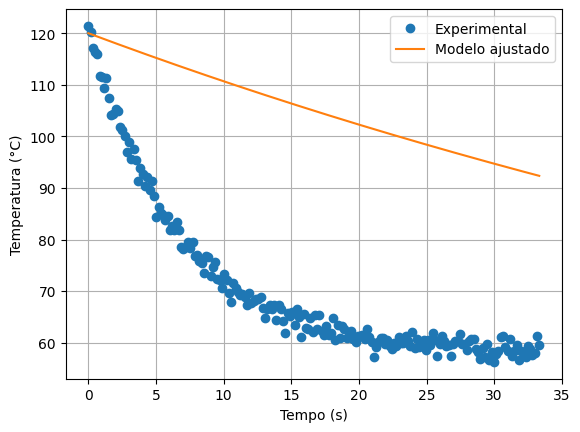

In [129]:
'''
BLOCO PARA PLOTAR O GRÁFICO

'''

#Plotar o gráfico
plt.figure()
plt.plot(tempo, T_exp, 'o', label='Experimental')
plt.plot(tempo, T_est, '-', label='Modelo ajustado')
plt.xlabel('Tempo (s)')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid()
plt.show()

Iter 0: h = 2000.12, qg = 1.00e+07
Iter 1: h = 2000.94, qg = 1.00e+07
Iter 2: h = 2001.74, qg = 1.00e+07
Iter 3: h = 2002.55, qg = 1.00e+07
Iter 4: h = 2003.34, qg = 1.00e+07
Iter 5: h = 2004.13, qg = 1.00e+07
Iter 6: h = 2004.92, qg = 1.00e+07
Iter 7: h = 2005.69, qg = 1.00e+07
Iter 8: h = 2006.46, qg = 1.00e+07
Iter 9: h = 2007.22, qg = 1.00e+07
Iter 10: h = 2007.98, qg = 1.00e+07
Iter 11: h = 2008.73, qg = 1.00e+07
Iter 12: h = 2009.48, qg = 1.00e+07
Iter 13: h = 2010.21, qg = 1.00e+07
Iter 14: h = 2010.95, qg = 1.00e+07
Iter 15: h = 2011.67, qg = 1.00e+07
Iter 16: h = 2012.39, qg = 1.00e+07
Iter 17: h = 2013.10, qg = 1.00e+07
Iter 18: h = 2013.81, qg = 1.00e+07
Iter 19: h = 2014.51, qg = 1.00e+07
Iter 20: h = 2015.21, qg = 1.00e+07
Iter 21: h = 2015.90, qg = 1.00e+07
Iter 22: h = 2016.58, qg = 1.00e+07
Iter 23: h = 2017.26, qg = 1.00e+07
Iter 24: h = 2017.93, qg = 1.00e+07
Iter 25: h = 2018.60, qg = 1.00e+07
Iter 26: h = 2019.26, qg = 1.00e+07
Iter 27: h = 2019.91, qg = 1.00e+07
It

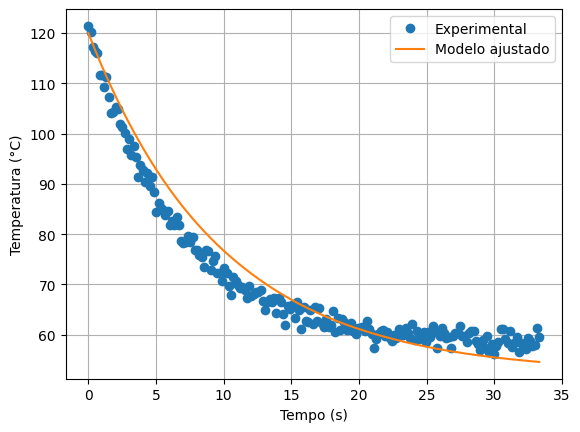

In [130]:
'''
BLOCO PARA IMPORTAR AS BIBLIOTECAS A SEREM UTILIZADAS
CERTOOO
'''

#Importação das bibliotecas a serem utilizadas

import numpy as np #Biblioteca para executar operações matemáticas
import pandas as pd #Leitor da minha planilha de dados
import matplotlib.pyplot as plt #Gerador de gráficos
from scipy.integrate import solve_ivp #Integração numérica para resolver a EDO

'''
BLOCO PARA LER MINHA PLANILHA DISPONÍVEL NO GITHUB

'''

#URL da planilha no Github

url = 'https://github.com/sayu0303/Otimiza-Nao-Linear/raw/refs/heads/main/problema6_lumped(corrigido).xlsx'

#Leitura da planilha

df_dados = pd.read_excel(url, header = 0) #Meu header é onde inicia-se a leitura da minha planilha


#Definição dos dados da planilha para utilização do código

t_exp = df_dados['t_s'].to_numpy() #Considera os valores da minha coluna t_s da planilha fornecida
tempo = t_exp.astype(float)
N = len(tempo)
T_exp = df_dados['T_C'].to_numpy() #Considera os valores da minha coluna T_C da planilha fornecida

'''
BLOCO PARA DEFINIR A MINHA EDO

'''

#Definição da EDO expostas no problema

def EDO (t, T, par):

  #Definição das constantes a serem utilizadas

  V = 2.5e-4 #Volume (m3)
  A = 0.045 #Área de troca térmica (m2)
  Tam = 25 #Temperatura ambiente constante (°C)
  p = 7800 #Densidade (kg/m3)
  c = 460 #Calor específico (J/kg.K)

  #Definir as variáveis propostas pelo problema

  h, qg = par #Definindo as variáveis como parametros

  #Definir a EDO

  dTdt = (qg*V/(p*c*V)) - ((h*A)*(T-Tam))/(p*c*V)

  return dTdt

'''
BLOCO PARA DEFINIR A SOLUÇÃO DA EDO

'''

#Definição a solução da EDO

def sol_EDO(par,tempo):

  #Definiçaõ da constante a ser utilizada na solução

  T0 = [120] #Temperatura inicial (°C).
  tspan = [float(tempo[0]), float(tempo[-1])] #Ler do primeiroo ao ultimo dado da planinha

  #Definição CURTA de uma função que se aplica as duas variaveis necessárias no solve_ivp

  redefinirEDO = lambda t, T: EDO(t, T, par) #Agora, a minha função EDO será definida apenas a tempo (t) e a temperatura (T)

  #Definição do solucionador da EDO

  sol = solve_ivp(redefinirEDO, tspan, T0, method = 'RK45', t_eval = tempo)

  T = sol.y[0]

  return T

  '''
BLOCO PARA A DEFINIÇÃO DA FUNÇÃO OBJETIVO (MÍNIMOS QUADRADOS)

'''

#Definição da minha função objetivo

def fun_obj (par, tempo, T_exp):

  #Renomear a função solução da EDO

  T = sol_EDO(par,tempo)

  #Definir o erro

  erro = (T_exp - T)**2

  Soma = np.sum(erro)

  return Soma

  '''
BLOCO PARA A DEFINIÇÃO DA FUNÇÃO GRADIENTE

'''

#Definição da função gradiente

def fun_gradiente(par, tempo, T_exp):


  #Definir o chute para testar o método

  chute = 50

  #Definir o gradiente

  grad = np.zeros(len(par))

  #Cópia do vetor parametro para evitar alteração no parametro original

  par_maish = par.copy()
  par_menosh = par.copy()

  #Para essa cópia, eu testo o erro somando ou subtraindo o termo do vetor que eu quero com o chute que eu fiz

  par_maish[0] = par_maish[0] + chute
  par_menosh[0] = par_menosh[0] - chute

  #Agora, calcular o gradiente para o termo h

  grad[0] = (fun_obj(par_maish, tempo, T_exp) - fun_obj(par_menosh, tempo, T_exp))/(2*chute)

  #Agora, repete-se em função do outro termo qg

  #Cópia do vetor parametro para evitar alteração no parametro original

  par_maisqg = par.copy()
  par_menosqg = par.copy()

  #Para essa cópia, eu testo o erro somando ou subtraindo o termo do vetor que eu quero com o chute que eu fiz

  par_maisqg[1] = par_maisqg[1] + chute
  par_menosqg[1] = par_menosqg[1] - chute

  #Agora, calcular o gradiente para o termo qg

  grad[1] = (fun_obj(par_maisqg, tempo, T_exp) - fun_obj(par_menosqg, tempo, T_exp))/(2*chute)

  return grad

  '''
BLOCO PARA A DEFINIÇÃO DO MÉTODO DE DFP

'''

#Definição do método de DFP

def metodo_DFP(par0, tempo, T_exp):

  par = par0.copy()

  #Definição da matriz identidade (inversa Hessiana)
  H = np.eye(2)

  #Declaração dos parâmetros do algoritmo
  passo = 0.01
  tol = 1e-6
  max_iter = 50

  #Para a quantidade de iteração

  for i in range(max_iter):

    #Definir o gradiente no ponto atual
    grad = fun_gradiente(par, tempo, T_exp)

    #Condição para convergência
    if np.linalg.norm(grad) < tol:
      break

    #Direção de descida que o método corrige

    direcao = - H @ grad

    #Definição de atualização de parâmetro

    par_novo = par + passo * direcao

    #Redefinição de um novo gradiente para um novo parametro

    grad_novo = fun_gradiente(par_novo, tempo, T_exp)

    #Atualização dos termos em relação ao novo com o antigo

    dif_par = par_novo - par
    dif_grad = grad_novo - grad

    #Comparação utilizando a inversa da Hessiana

    H = (H + np.outer(dif_par, dif_par) / (dif_par @ dif_grad) - np.outer(H @ dif_grad, H @ dif_grad) / (dif_grad @ H @ dif_grad))

    #Atualização dos parâmetros

    par = par_novo

    #Imprimindo o que o método achou

    print(f"Iter {i}: h = {par[0]:.2f}, qg = {par[1]:.2e}")

  return par

'''
BLOCO PARA A CHAMADA DO MÉTODO DE DFP

'''

#Chute inicial

par0 = np.array([2000,1e7])

par_otimo = metodo_DFP(par0, tempo, T_exp)

h_est  = par_otimo[0]
qg_est = par_otimo[1]

print(f"Parâmetros ótimos: h = {h_est:.2f}, qg = {qg_est:.2e}")

#Temperatura ajustada

T_est = sol_EDO(par_otimo, tempo)

'''
BLOCO PARA PLOTAR O GRÁFICO

'''

#Plotar o gráfico
plt.figure()
plt.plot(tempo, T_exp, 'o', label='Experimental')
plt.plot(tempo, T_est, '-', label='Modelo ajustado')
plt.xlabel('Tempo (s)')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid()
plt.show()